In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# Models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, Model, evaluator

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [2]:
# Macros
CLASS_COL = "class"
META_LABEL_METRIC = "precision"

OFFLINE_PHASE_SIZE = 10000
BASE_TRAIN_SIZE = 7000
R_STATE = 123

ETA = 100  # Window size used to extract meta features
STEP = 30  # Step for next meta learning iteration
TARGET_DELAY = 500

## Read data

In [3]:
f = open("../datasets/real/elec.arff", "r")
data, meta = arff.loadarff(f)

df = pd.DataFrame(data)
df['weekday'] = pd.to_numeric(df['day'])
df['class'] = df['class'].str.decode("utf-8")
df = df.drop(['date', 'period', 'day'], axis=1)

print(df.shape)
df.head()

(45312, 7)


,nswprice,nswdemand,vicprice,vicdemand,transfer,class,weekday
0,0.056443,0.439155,0.003467,0.422915,0.414912,UP,2
1,0.051699,0.415055,0.003467,0.422915,0.414912,UP,2
2,0.051489,0.385004,0.003467,0.422915,0.414912,UP,2
3,0.045485,0.314639,0.003467,0.422915,0.414912,UP,2
4,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,2


In [4]:
n = df.shape[0]
class_weight = df[CLASS_COL].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5754546257062146, 'UP': 0.4245453742937853}

In [5]:
# offline
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
base_train_df = offline_df.iloc[:BASE_TRAIN_SIZE]
meta_train_df = offline_df.iloc[BASE_TRAIN_SIZE:]

# online
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
online_features = online_df.drop(CLASS_COL, axis=1).reset_index(drop=True)
online_targets = online_df[CLASS_COL].reset_index(drop=True)

## Fase offline

In [6]:
base_model = Model(verbose=True, basis_model=RandomForestClassifier, hyperparameters={"max_depth": 6, "warm_start": True, "min_samples_split": 0.05})
meta_model = Model(verbose=True, basis_model=ltb.LGBMRegressor, hyperparameters={"num_leaves": 21, "max_depth": 5})
learner_params = {
    "base_model": base_model,
    "meta_model": meta_model,
    "base_model_class_column": CLASS_COL,
    "eta": ETA,
    "step": STEP,
    "meta_label_metric": META_LABEL_METRIC,
    "verbose": True,
    "target_delay": TARGET_DELAY,
    }

learner = MetaLearner(**learner_params).fit(base_train_df, meta_train_df)

Training model with instances 0 to 97
Training model with instances 0 to 97


## Fase online

In [7]:
# start - no target
with tqdm(total=TARGET_DELAY) as pbar:
    for i, row in online_features.iloc[:TARGET_DELAY].iterrows():
        learner.update(row)
        pbar.update(1)

100%|██████████| 500/500 [00:34<00:00, 14.52it/s]


In [8]:
# middle - both target and instances
df = online_features.iloc[TARGET_DELAY:-TARGET_DELAY]

with tqdm(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        learner.update(row)
        learner.update_target(online_targets.iloc[i - TARGET_DELAY])
        pbar.update(1)

  3%|▎         | 901/34312 [01:25<45:04, 12.36it/s]  

Training model with instances 30 to 127


  5%|▌         | 1801/34312 [02:36<42:25, 12.77it/s]  

Training model with instances 60 to 157


  8%|▊         | 2701/34312 [03:48<37:58, 13.87it/s]  

Training model with instances 90 to 187


 10%|█         | 3602/34312 [04:57<35:46, 14.31it/s]  

Training model with instances 120 to 217


 13%|█▎        | 4501/34312 [06:38<48:57, 10.15it/s]  

Training model with instances 150 to 247


 16%|█▌        | 5401/34312 [08:01<43:51, 10.99it/s]  

Training model with instances 180 to 277


 18%|█▊        | 6300/34312 [09:24<42:36, 10.96it/s]  

Training model with instances 210 to 307


 21%|██        | 7202/34312 [10:49<37:56, 11.91it/s]  

Training model with instances 240 to 337


 24%|██▎       | 8100/34312 [12:14<42:22, 10.31it/s]  

Training model with instances 270 to 367


 26%|██▌       | 9000/34312 [13:40<36:25, 11.58it/s]  

Training model with instances 300 to 397


 29%|██▉       | 9900/34312 [15:09<41:30,  9.80it/s]  

Training model with instances 330 to 427


 31%|███▏      | 10801/34312 [16:38<52:51,  7.41it/s]  

Training model with instances 360 to 457


 34%|███▍      | 11701/34312 [18:01<32:43, 11.52it/s]  

Training model with instances 390 to 487


 37%|███▋      | 12600/34312 [19:25<32:06, 11.27it/s]  

Training model with instances 420 to 517


 39%|███▉      | 13501/34312 [20:52<29:01, 11.95it/s]  

Training model with instances 450 to 547


 42%|████▏     | 14401/34312 [22:15<29:30, 11.25it/s]  

Training model with instances 480 to 577


 45%|████▍     | 15302/34312 [23:43<19:59, 15.85it/s]  

Training model with instances 510 to 607


 47%|████▋     | 16202/34312 [24:45<19:56, 15.13it/s]  

Training model with instances 540 to 637


 50%|████▉     | 17102/34312 [25:49<20:21, 14.09it/s]  

Training model with instances 570 to 667


 52%|█████▏    | 18001/34312 [27:02<34:42,  7.83it/s]  

Training model with instances 600 to 697


 55%|█████▌    | 18901/34312 [28:21<25:58,  9.89it/s]  

Training model with instances 630 to 727


 58%|█████▊    | 19801/34312 [29:54<20:55, 11.56it/s]  

Training model with instances 660 to 757


 60%|██████    | 20701/34312 [31:19<21:25, 10.59it/s]  

Training model with instances 690 to 787


 63%|██████▎   | 21600/34312 [33:10<38:21,  5.52it/s]  

Training model with instances 720 to 817


 66%|██████▌   | 22499/34312 [35:15<25:54,  7.60it/s]  

Training model with instances 750 to 847


 68%|██████▊   | 23402/34312 [36:30<12:46, 14.23it/s]

Training model with instances 780 to 877


 71%|███████   | 24302/34312 [37:41<16:29, 10.11it/s]

Training model with instances 810 to 907


 73%|███████▎  | 25201/34312 [38:49<12:14, 12.41it/s]

Training model with instances 840 to 937


 76%|███████▌  | 26101/34312 [40:02<09:53, 13.83it/s]

Training model with instances 870 to 967


 79%|███████▊  | 27001/34312 [41:11<10:16, 11.85it/s]

Training model with instances 900 to 997


 81%|████████▏ | 27900/34312 [42:27<11:54,  8.97it/s]

Training model with instances 930 to 1027


 84%|████████▍ | 28800/34312 [44:01<09:04, 10.12it/s]

Training model with instances 960 to 1057


 87%|████████▋ | 29701/34312 [45:32<07:07, 10.79it/s]

Training model with instances 990 to 1087


 89%|████████▉ | 30600/34312 [47:16<05:29, 11.26it/s]

Training model with instances 1020 to 1117


 92%|█████████▏| 31501/34312 [48:45<07:14,  6.47it/s]

Training model with instances 1050 to 1147


 94%|█████████▍| 32400/34312 [50:22<03:40,  8.69it/s]

Training model with instances 1080 to 1177


 97%|█████████▋| 33300/34312 [51:45<01:43,  9.78it/s]

Training model with instances 1110 to 1207


100%|█████████▉| 34201/34312 [53:05<00:09, 12.11it/s]

Training model with instances 1140 to 1237


100%|██████████| 34312/34312 [53:15<00:00, 10.74it/s]


In [9]:
# end - only targets
with tqdm(total=TARGET_DELAY) as pbar:
    for target in online_targets.tail(TARGET_DELAY):
        learner.update_target(target)
        pbar.update(1)

100%|██████████| 500/500 [00:00<00:00, 504.79it/s]


## Results

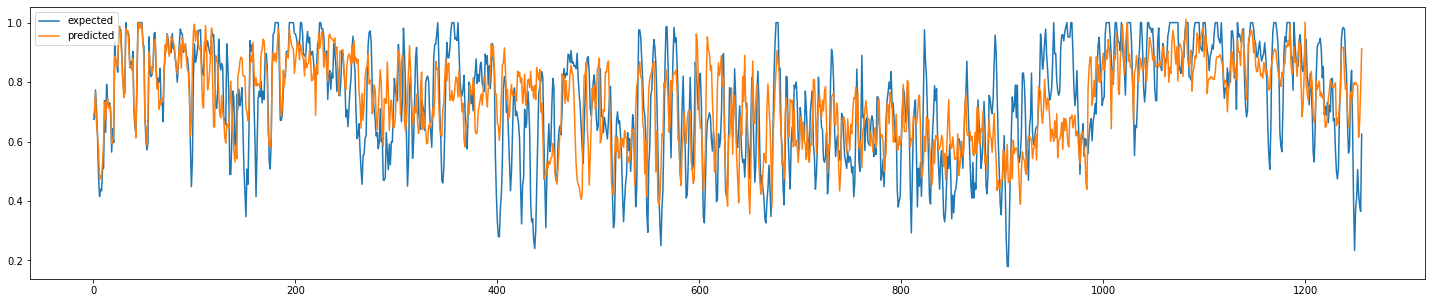

In [10]:
mb = learner.metabase.metabase

y_true = mb['precision']
y_pred = mb['predicted']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

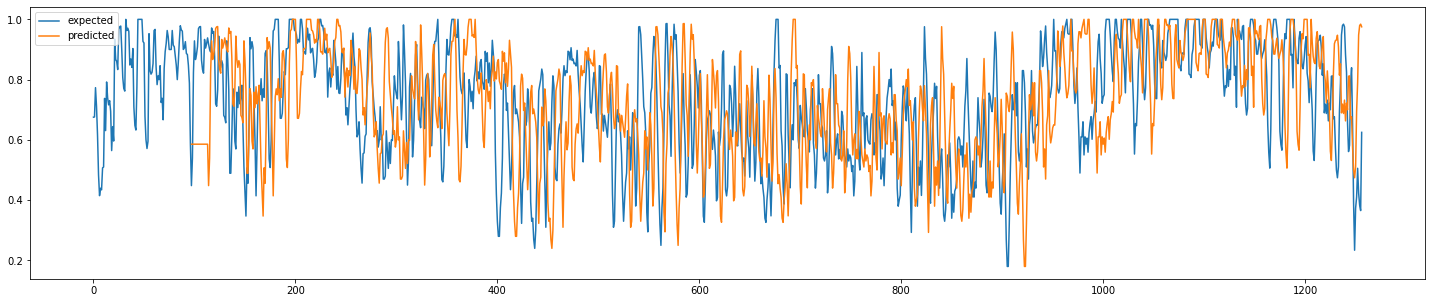

In [12]:
mb = learner.metabase.metabase

y_true = mb['precision']
y_pred = mb['last_precision']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

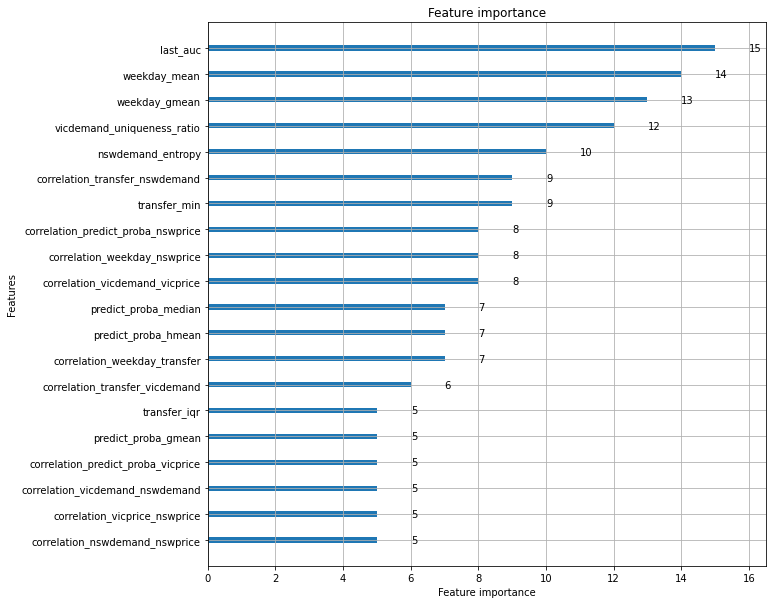

In [14]:
model = learner.meta_model.model
ltb.plot_importance(model, figsize=(10, 10), max_num_features=20)

In [19]:
from meta_learning import evaluator
import numpy as np

y_true = mb['precision']
y_pred = mb['predicted']

print(f"r2: {evaluator.evaluate(y_true, y_pred, 'r2')}")
print(f"mse: {evaluator.evaluate(y_true, y_pred, 'mse')}")
print(f"std: {np.std(y_true - y_pred)}")

r2: 0.37377601962785034
mse: 0.020683321006463046
std: 0.14377216797699097


In [15]:
mb.to_csv("all_metrics_with_last_performance.csv", index=False)

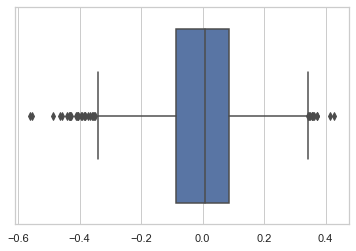

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=y_true-y_pred)